In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

def rk4_step(func, y, t, dt, m):
    k1 = dt * func(y, t, m)
    k2 = dt * func(y + k1/2, t + dt/2, m)
    k3 = dt * func(y + k2/2, t + dt/2, m)
    k4 = dt * func(y + k3,   t + dt, m)
    y += (1/6) * (k1 + 2*k2 +2*k3 + k4)
    return y

def rk4(func, init, t, m):
    num_variables = len(init)
    y = np.zeros((len(t), num_variables))
    y[0,:] = init
    for i in range(0, len(t)-1):
        dt = t[i+1] - t[i]
        y[i+1,:] = rk4_step(func, y[i,:], t[i], dt, m)
    return y

In [56]:
# Global constants for earth
G = 6.6742*10**-11 # gravitational constant, Nm^2/kg^2
M = 5.9722*10**24 # mass of earth, kg
R = 6371*10**3 # radius of earth, m
omega = 7.2921e-5

# Global constants for rocket
m = 299999999999
A = np.pi*8.7**2
C_d = 1

m_shuttle = 80e3
m_primary = 1.2e6
m_secondary = 100e3

t_burn_primary = 100

dm_dt1 = m_primary / t_burn_primary

In [73]:
def force_gravity(m, x, y):
    '''Calculate the force of gravity on a mass m due to earth.
    
    Parameters:
    
    m : mass of object [kg]
    x : x distance away from the center of earth [m]
    y : y distance away from the center of earth [m]
    
    Returns:
    
    F_g_x, F_g_y: Force on mass m due to gravity in x and y directions respectively [N]'''
    
    # force magnitude
    F_g = G*M*m/(x**2 + y**2)
    
    # Polar angle measured counterclockwise from the x axis
    theta = np.arctan2(y,x)
    
    # Draw a simple free-body diagram to derive these. The gravitational force is always radially inward.
    # Break the vector into components and you can easily see the relationshp coded below. I'll upload a diagram soon.
    F_g_x = F_g * np.cos(theta)
    F_g_y = F_g * np.sin(theta)
    
    return F_g_x, F_g_y

def air_density(m, x, y):
    '''Calculate (a close approximation of) the air density at a given distance away from the center of earth.
    
    Parameters:
    
    m : mass of object [kg]
    x : x distance away from the center of earth [m]
    y : y distance away from the center of earth [m]
    
    Returns:
    
    Density at point (x,y) [kg/m^3]'''
    
    
    rho_0 = 1.225 # sea level density, kg/m^3
    L = 0.0065 # temperature lapse rate, K/m
    T = 288.15 # temperature, K. Temperature is obviously NOT constant and this is a simplification
    M = 0.0289644 # molar mass of dry air, kg/mol
    R_gas = 8.31447 # ideal gas constant, J/(mol K)
    
    F_g_x, F_g_y = force_gravity(m, x, y) 
    g = np.sqrt(F_g_x**2 + F_g_y**2)/m # acceleration due to gravity at (x, y) [m/s^2]
    r = np.sqrt(x**2 + y**2)
    
    # Equation pulled from Wikipedia
    rho = rho_0 * np.exp(-g*M*(r-R)/(R_gas*T))
    
    # @TODO: Consider atmosphere...that has a density...

    return rho

def force_drag(m, x, y, vx, vy):
    '''Return the drag force and object experiences during flight.
    
    Parameters:
    
    m : mass of object [kg]
    x : x distance away from the center of earth [m]
    y : y distance away from the center of earth [m]
    vx : x velocity of object
    vy : y velocity of object
    
    Returns:
    
    F_drag_x, F_drag_y: Force due to drag in x and y directions respectively [N]'''
    
    rho = air_density(m, x, y)
    
    b = 1/(2*m) * rho * A * C_d
    
    # Dr. Wood-Vasey derived these in class for hw7 and hw8. The formulas are identical to his work.
    F_drag_x = b*np.sqrt(vx**2 + vy**2)*vx
    F_drag_y = b*np.sqrt(vx**2 + vy**2)*vy

    return F_drag_x, F_drag_y


def acceleration(m, t, x, y, vx, vy):
    '''Return the net acceleration of the rocket.
    
    Parameters:
    
    m : mass of object [kg]
    t : time [s]
    x : x distance away from the center of earth [m]
    y : y distance away from the center of earth [m]
    vx : x velocity of object
    vy : y velocity of object
    
    Returns:
    
    acceleration_net_x, acceleration_net_y : net acceleration in the x and y directions respectively [m/s^2]
    '''
    
    m = mass(t)
    
    # Retrieve forces 
    F_g_x, F_g_y = force_gravity(m, x, y)
    F_drag_x, F_drag_y = force_drag(m, x, y, vx, vy)
    F_T_x, F_T_y = force_thrust(t, x, y)
    
    # Gravitational forces are always attractive and drag forces oppose the direction of motion.
    # Hence, both of those are negative. Thrust is obviously positive.
    acceleration_net_x = (-F_g_x - F_drag_x + F_T_x)/m
    acceleration_net_y = (-F_g_y - F_drag_y + F_T_y)/m

    return acceleration_net_x, acceleration_net_y

def F(init, t, m):
    '''Function to be integrated with odeint.'''

    x, y = init[0], init[1]
    vx, vy = init[2], init[3]
    ax, ay = acceleration(m, t, x, y, vx, vy)
    
    return np.array([vx, vy, ax, ay])


def print_init(init):
    print('INITIAL CONDITIONS')
    print('x =', init[0])
    print('y =', init[1])
    print('vx =', init[2])
    print('vy =', init[3])

Max height of 17128222.4742 m at t = 5109.5109511 s
vtheta = -3188.71103065 m/s at this time.
We need a boost of 1635.3259929 m/s to get to orbital speed at this height.
Fire secondary boosters at t = 5062.98218432 s for 46.5287667752 s


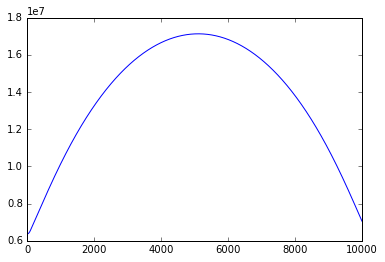

In [77]:
dm_dt2 = 1500
F_T_primary = 60e6
F_T_secondary = 5e6

def mass(t):
    
    if t <= t_burn_primary:
        
        return m_shuttle + m_secondary +  m_primary - dm_dt1 * t
        
    return m_shuttle + m_secondary

def force_thrust(t, x, y):

    if t <= t_burn_primary:
        
        return (((F_T_primary) * np.sin(np.pi/2 * t/t_burn_primary)), 
                 (F_T_primary) * np.cos(np.pi/2 * t/t_burn_primary))
    
    return 0,0

def approximate_boost_info(init, t_max, N):
    # Create time array
    T = np.linspace(0, t_max, N)
    
    # Integrate F
    data = odeint(F, init, T, (m,))

    # Extract data
    x, y, vx, vy = data[:,0], data[:, 1], data[:,2], data[:,3]
    
    r = np.sqrt(x**2+y**2)
    theta = np.arctan2(y, x)
    
    vr = vx*np.cos(theta) + vy*np.sin(theta)
    vtheta = - vx*np.sin(theta) + vy*np.cos(theta)
    
    max_r_index = np.argmax(r)
    max_r_time = T[max_r_index]
    max_r = np.max(r)
    
    max_r_vtheta = vtheta[max_r_index]
    
    v_boost = np.sqrt(G*M/max_r) - abs(max_r_vtheta)
    #t_boost = (v_boost/(5e6/(m_shuttle)) + v_boost/(5e6/(m_shuttle + m_secondary)))/2
    t_boost = (m_shuttle + m_secondary)/1500 * (1 - np.exp(-dm_dt2 * v_boost / F_T_secondary))
    
    print('Max height of', max_r, 'm at t =', max_r_time, 's')
    print('vtheta =', max_r_vtheta, 'm/s at this time.\n' 
          'We need a boost of', v_boost, 'm/s to get to orbital speed at this height.')
    print('Fire secondary boosters at t =', max_r_time-t_boost, 's for', t_boost, 's')
    
    plt.plot(T, r)
    
    return max_r_time-t_boost, max_r_time, t_boost


v0 = 7.29e-5*R
init1 = np.array([0, R, v0, 0])
t_secondary_start, t_secondary_stop, t_burn_secondary = approximate_boost_info(init1,10000,10000)

5062.98218432 5109.5109511 46.5287667752


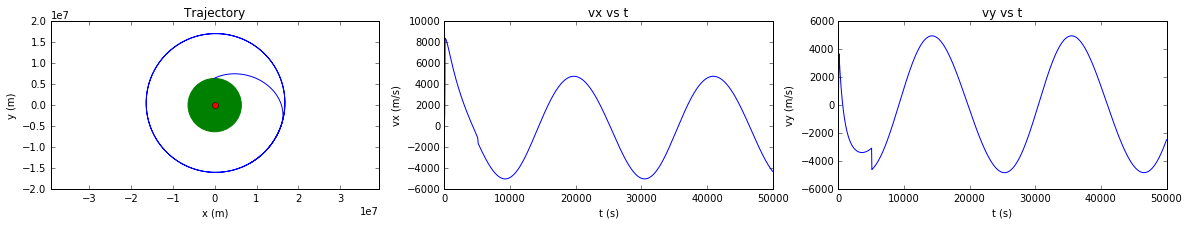

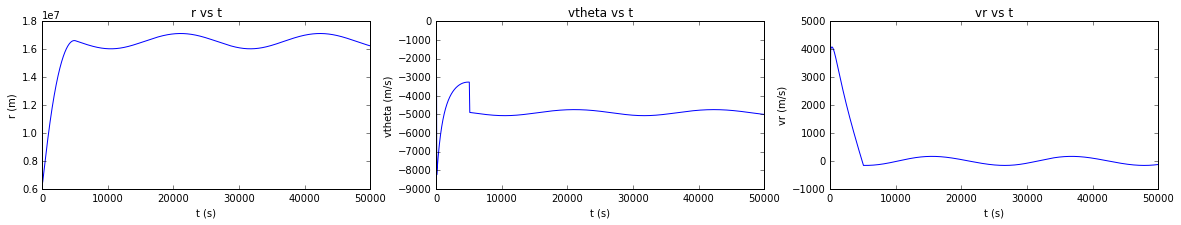

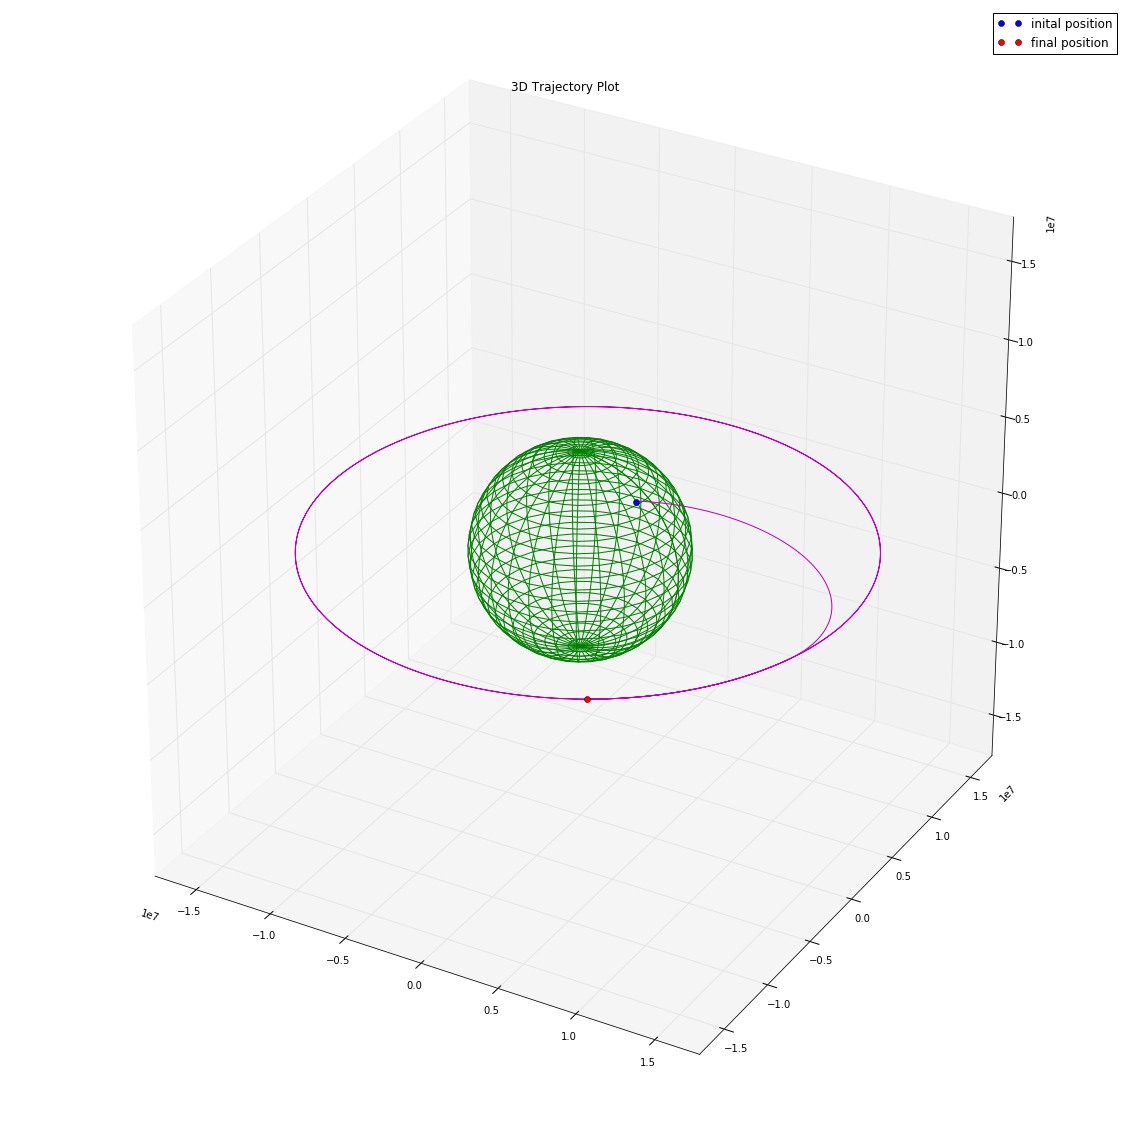

In [79]:
print(t_secondary_start, t_secondary_stop, t_burn_secondary)

def mass(t):
        
    if t <= t_burn_primary:
        
        return m_shuttle + m_secondary + m_primary - dm_dt1 * t
    
    elif t > t_burn_primary and t < t_secondary_start:
        
        return m_shuttle + m_secondary
    
    elif t >= t_secondary_start and t <= t_secondary_stop:

        return m_shuttle + m_secondary - dm_dt2 * (t - t_secondary_start)

    return m_shuttle + m_secondary * (t_burn_secondary)


def force_thrust(t, x, y):
    theta = np.arctan2(y, x)
    
    if t <= t_burn_primary:
        
        return (((F_T_primary) * np.sin(np.pi/2 * t/t_burn_primary)), 
                 (F_T_primary) * np.cos(np.pi/2 * t/t_burn_primary))
    
    elif t >= t_secondary_start and t <= t_secondary_stop:

        return F_T_secondary * np.sin(theta), - F_T_secondary * np.cos(theta)
    
    return 0,0



def test(init, t_max, N):
    
    # Create time array
    T = np.linspace(0, t_max, N)
        
    # Integrate F
    data = rk4(F, init, T, m)
    
    # Extract data
    x, y, vx, vy = data[:,0], data[:, 1], data[:,2], data[:,3]
        
    plt.figure(figsize=(20,3))
    
    # Plot trajectory
    plt.subplot(1,3,1)
    plt.plot(x, y)
    plt.title('Trajectory')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.axis('equal')
    plt.plot(0, 0, 'ro')

    # Draw a circle to represent earth
    earth = plt.Circle((0,0), R, color='green')
    plt.subplot(1,3,1).add_patch(earth)
        
    # Plot vx vs t
    plt.subplot(1,3,2)
    plt.plot(T, vx)
    plt.title('vx vs t')
    plt.xlabel('t (s)')
    plt.ylabel('vx (m/s)')

    # Plot vy vs t
    plt.subplot(1,3,3)
    plt.plot(T, vy)
    plt.title('vy vs t')
    plt.xlabel('t (s)')
    plt.ylabel('vy (m/s)')
    plt.show()
    
    plt.figure(figsize=(20,3))
        
    # Plot r vs t
    plt.subplot(1,3,1)
    plt.plot(T, np.sqrt(x**2+y**2))
    plt.title('r vs t')
    plt.xlabel('t (s)')
    plt.ylabel('r (m)')
    
    theta = np.arctan2(y, x)
    vtheta = - vx*np.sin(theta) + vy*np.cos(theta)
    vr = vx*np.cos(theta) + vy*np.sin(theta)
    
    plt.subplot(1,3,2)
    plt.plot(T, vtheta)
    plt.title('vtheta vs t')
    plt.xlabel('t (s)')
    plt.ylabel('vtheta (m/s)')
    
    plt.subplot(1,3,3)
    plt.plot(T, vr)
    plt.title('vr vs t')
    plt.xlabel('t (s)')
    plt.ylabel('vr (m/s)')
    plt.show()
    
    # Create 3D plot
    fig = plt.figure(figsize=(20,20))
    ax = fig.gca(projection='3d')
    
    # Set z = 0 for all times t
    z = np.zeros_like(x)

    # Plot trajectory in 3D
    ax.plot(x, y, z, 'm')
    
    # Plot initial and final positions
    ax.plot([x[0]], [y[0]], [z[0]], 'bo', label='inital position')
    ax.plot([x[-1]], [y[-1]], [z[-1]], 'ro', label='final position')
    
    plt.legend(loc='best')
    
    # Create wireframe sphere to represent earth
    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:30j]
    X = R*np.cos(u)*np.sin(v)
    Y = R*np.sin(u)*np.sin(v)
    Z = R*np.cos(v)
    ax.plot_wireframe(X, Y, Z, color="green")
    
    # Set axes limits. We want the scales to be equal, and we want to make sure we include the entire trajectory.
    # So, set the maximum limit to the largest x, y, or z value that appears 
    max_limit = max(np.max(x), np.max(y), np.max(z))
    ax.set_xlim(-max_limit, max_limit)
    ax.set_ylim(-max_limit, max_limit)
    ax.set_zlim(-max_limit, max_limit)
    
    plt.title('3D Trajectory Plot')

    plt.show()


t_max = 50000
test(init1, t_max, t_max)

In [ ]:
def plot_mass_vs_time():
    print(t_secondary_start, t_secondary_stop)
    T = np.linspace(0,1500,3000)
    masses = [ ]
    for t in T:
        masses.append(mass(t))
    plt.plot(T, masses)